<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.


## Imports


In [659]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

## Utilities


In [660]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Load and Preview the Dataset


In [661]:
paris_df = pd.read_csv('./data/metropoles_consumption/eco2mix-Paris.csv', sep=';')
paris_df.head()

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,21:15,2023-09-05T21:15:00+02:00,3618.0,ND,3598
1,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,23:30,2023-09-05T23:30:00+02:00,3278.0,ND,3262
2,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:00,2023-09-06T00:00:00+02:00,3034.0,ND,3018
3,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:15,2023-09-06T00:15:00+02:00,2941.0,ND,2921
4,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:30,2023-09-06T00:30:00+02:00,2877.0,ND,2857


In [662]:
# order the dataframe by increasing date, then hour
paris_df = paris_df.sort_values(by=['Date', 'Heures'])
paris_df.head(5)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
227349,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:15,2017-02-13T01:15:00+01:00,4917.0,NaN,NaN
103575,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:30,2017-02-13T01:30:00+01:00,4774.0,NaN,NaN
194843,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:45,2017-02-13T01:45:00+01:00,4716.0,NaN,NaN
194844,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:00,2017-02-13T02:00:00+01:00,4660.0,NaN,NaN
227350,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:15,2017-02-13T02:15:00+01:00,4695.0,NaN,NaN


In [663]:
# see the number of rows where consumption = 0
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

# remove rows where consumption = 0
paris_df = paris_df[paris_df['Consommation (MW)'] != 0]
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

Number of rows with consumption data = 0:  120
Number of rows with consumption data = 0:  0


In [664]:
# display nan values
paris_df.isna().sum()



Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)       3003
Production            179707
Echanges physiques    179707
dtype: int64

In [665]:
# drop rows with nan values in the consumption column
paris_df = paris_df.dropna(subset=['Consommation (MW)'])

# display nan values
paris_df.isna().sum()

Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)          0
Production            177141
Echanges physiques    177141
dtype: int64

In [666]:
# get time series of consumption
paris_consumption = paris_df['Consommation (MW)']

# get accompanying timesteps (date+hour converted to datetime)
paris_time = pd.to_datetime(paris_df['Date'] + ' ' + paris_df['Heures'], format='%Y-%m-%d %H:%M')


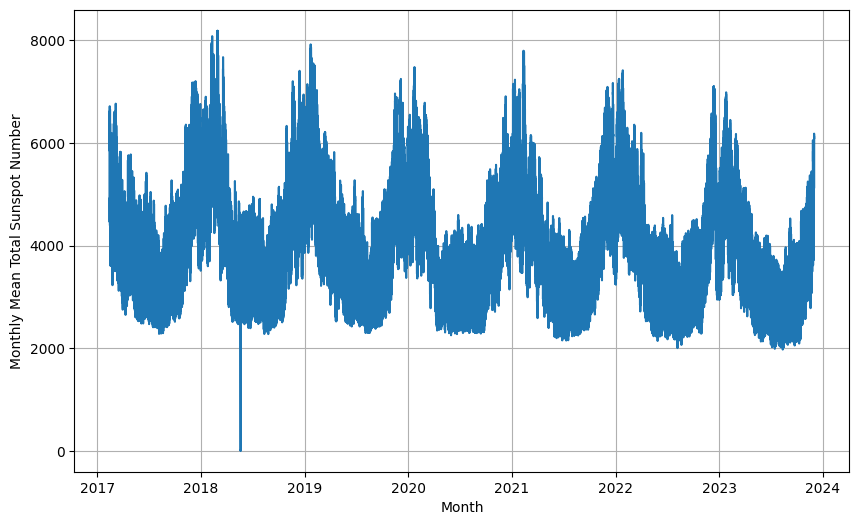

In [667]:

# Convert lists to numpy arrays
time = np.array(paris_time)
series = np.array(paris_consumption)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [668]:
# print datatype of time
print('Time datatype: ', time.dtype)

# print datatype of series
print('Series datatype: ', series.dtype)

Time datatype:  datetime64[ns]
Series datatype:  float64


In [669]:
# convert datetime to timesteps (integer values)
time = np.array(range(len(paris_time)))

# print data type
print('Data type of series:', series.dtype)

# print data type
print('Data type of time:', time.dtype)


Data type of series: float64
Data type of time: int32


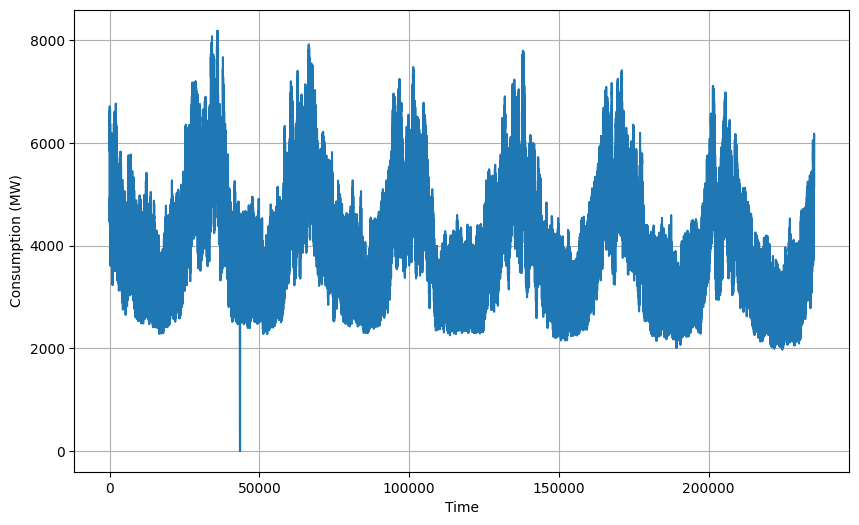

In [670]:
# plot the time series
plot_series(time, series, xlabel='Time', ylabel='Consumption (MW)')

## Split the Dataset


In [671]:
# Define the split time
split_time = 235000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels


In [672]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.


In [673]:
# Parameters
window_size = 5
batch_size = 256
shuffle_buffer_size = 10000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.


In [674]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 5000)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             256       
                                                                 
 lstm (LSTM)                 (None, 5, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.


In [675]:
# Get initial weights
init_weights = model.get_weights()

In [676]:
# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

# # Initialize the optimizer
# optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# # Set the training parameters
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# # Train the model
# history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

In [677]:
# # Define the learning rate array
# lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# # Set the figure size
# plt.figure(figsize=(10, 6))

# # Set the grid
# plt.grid(True)

# # Plot the loss in log scale
# plt.semilogx(lrs, history.history["loss"])

# # Increase the tickmarks size
# plt.tick_params('both', length=10, width=1, which='both')

# # Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 1000])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.


In [678]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [679]:
# Set the learning rate
learning_rate = 1e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [680]:
# Train the model
history = model.fit(train_set,epochs=5)

Epoch 1/5


918/918 [==============================] - 19s 17ms/step - loss: 1394.3025 - mae: 1394.8025
Epoch 2/5
918/918 [==============================] - 16s 17ms/step - loss: 889.4838 - mae: 889.9838
Epoch 3/5
918/918 [==============================] - 17s 18ms/step - loss: 889.4389 - mae: 889.9387
Epoch 4/5
918/918 [==============================] - 16s 17ms/step - loss: 888.5431 - mae: 889.0428
Epoch 5/5
918/918 [==============================] - 16s 17ms/step - loss: 888.6306 - mae: 889.1306


You can visualize the training and see if the loss and MAE are still trending down.


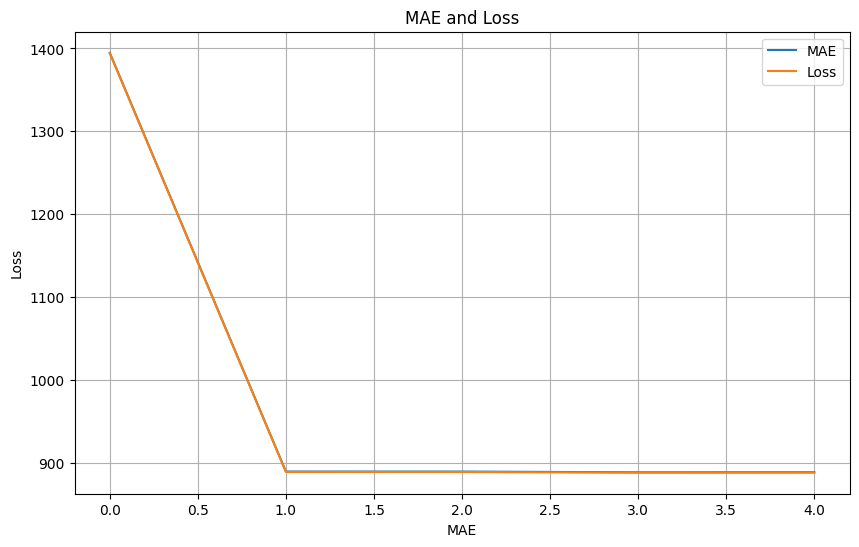

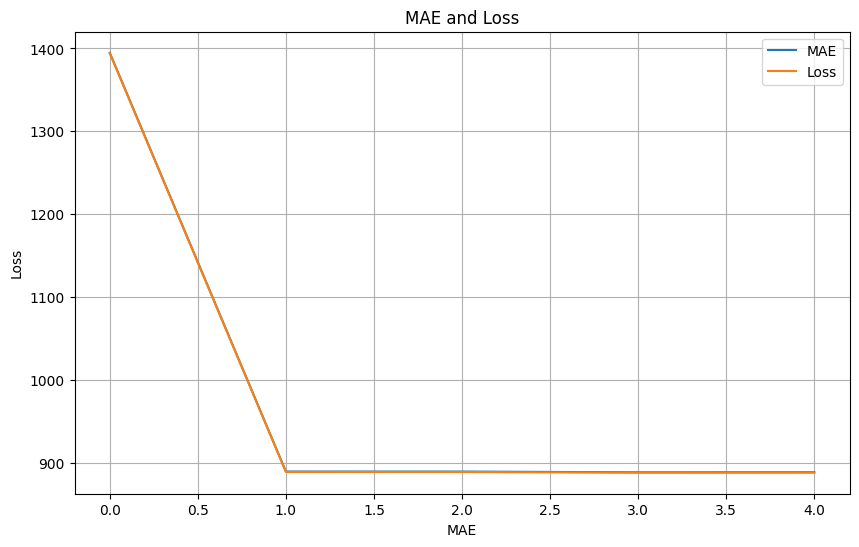

In [681]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.


In [682]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

Forecast series shape (244,)
Forecast series [5663. 5632. 5628. 5623. 5659. 5690. 5693. 5655. 5634. 5634. 5556. 5559.
 5536. 5469. 5453. 5394. 5345. 5316. 5196. 5220. 5261. 5252. 5301. 5258.
 5345. 5387. 5450. 5569. 5600. 5657. 5659. 5688. 5773. 5788. 5746. 5771.
 5773. 5687. 5595. 5517. 5396. 5353. 5224. 5077. 5001. 5026. 4956. 4939.
 5033. 4949. 4955. 4826. 4717. 4606. 4500. 4392. 4271. 4169. 4061. 3995.
 3930. 3887. 3874. 3800. 3785. 3766. 3756. 3738. 3721. 3716. 3737. 3734.
 3741. 3820. 3904. 3921. 4031. 4049. 4297. 4357. 4507. 4698. 5000. 5096.
 5296. 5372. 5536. 5577. 5659. 5686. 5652. 5762. 5745. 5781. 5754. 5721.
 5706. 5722. 5715. 5737. 5728. 5742. 5770. 5735. 5705. 5676. 5653. 5620.
 5569. 5599. 5539. 5474. 5426. 5361. 5348. 5405. 5386. 5354. 5393. 5403.
 5411. 5533. 5583. 5665. 5670. 5715. 5767. 5790. 5877. 5924. 5891. 5865.
 5804. 5783. 5648. 5584. 5480. 5388. 5280. 5188. 5093. 5111. 5027. 5052.
 5090. 5044. 5050. 4921. 4813. 4706. 4606. 4488. 4383. 4260. 4165. 4084.
 4020.

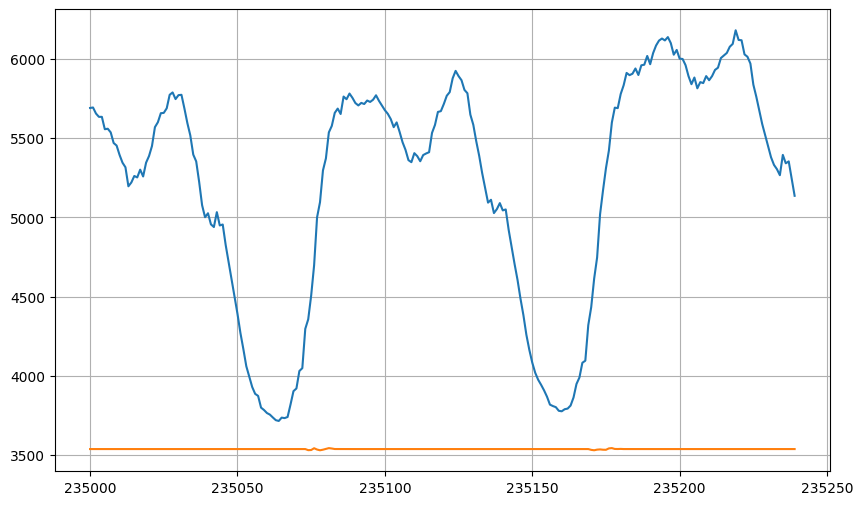

In [683]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]
print('Forecast series shape', forecast_series.shape)
print('Forecast series', forecast_series)

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)
print('Forecast shape', forecast.shape)
print('Forecast', forecast)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

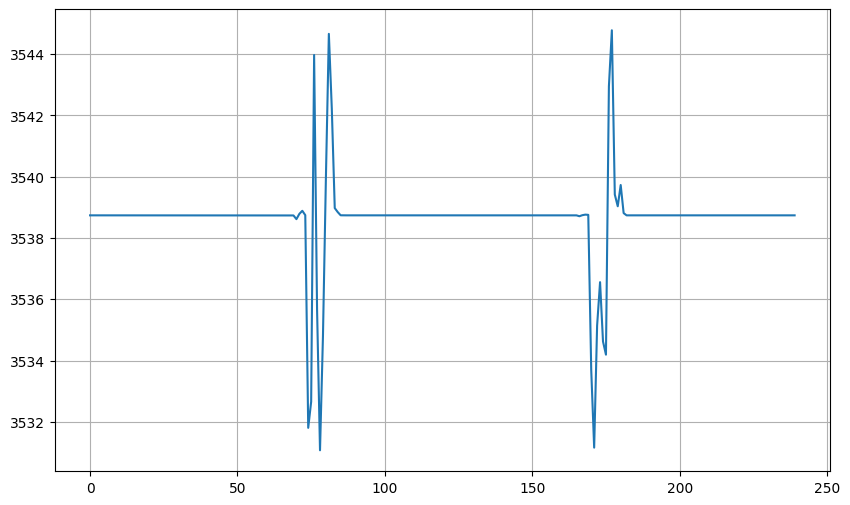

In [684]:
# plot forecast series
plot_series(np.arange(len(forecast)), forecast)

In [685]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1680.5172


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!


## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.


In [686]:
# # Initialize the optimizer
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# # Set the training parameters
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# # Train the model
# history = model.fit(train_set,epochs=10)

At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.


In [687]:
# # Set the initial learning rate
# initial_learning_rate=1e-7

# # Define the scheduler
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=400,
#     decay_rate=0.96,
#     staircase=True)

# # Set the optimizer
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# # Set the training parameters
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# # Train the model
# history = model.fit(train_set,epochs=40)

Now see the results by geting predicitons and computing the metrics.


In [688]:
# # Reduce the original series
# forecast_series = series[split_time-window_size:-1]

# # Use helper function to generate predictions
# forecast = model_forecast(model, forecast_series, window_size, batch_size)

# # Drop single dimensional axis
# results = forecast.squeeze()

# # Plot the results
# plot_series(time_valid, (x_valid, results))

In [689]:
# # Compute the MAE
# tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()